# Homework 5 - Group 11

In this assignment we perform an analysis of the Wikipedia Hyperlink graph. In particular, given extra information about the categories to which an article belongs to, we are curious to rank the articles according to some criteria.

For this purpose we use the Wikipedia graph released by the SNAP group.

## Before starting - Clean the category

### Importing libraries

In [1]:
from collections import defaultdict
import json
import numpy as np
import pickle

### Find the unique nodes

We read the file to count and save all the nodes we find.

In [2]:
nodes_file = open("wiki-topcats-reduced.txt", "r") 

unique_nodes = set()

for edge in nodes_file:
    unique_nodes.update( map(int, edge.split()) )

nodes_file.close()

### How many nodes we consider?

In [3]:
len(unique_nodes)

461193

### Create a default dict for the categories

Then we consider the file with the categories and the nodes that belong to them. However there are some categories that have been removed from the graph. So we select only the categories that have at least one node in the "unique_node" set. Another criterion for the choice is taking into account all the categories that have number of articles greater than 3500 in the category file.

In [4]:
category_dict = defaultdict()

categ_file = open("wiki-topcats-categories.txt", "r") 

for categ in categ_file:
    list_row = categ.split(";")
    category_dict[list_row[0][9:]] = list(map(int,list_row[1].split()))

### How many categories the file contain?

In [5]:
len(category_dict.keys())

17364

Now we look for the categories to delete and we store them into a list.

We delete each key that has the a number of nodes lower than 3500.

In [6]:
key_to_delete = [key for key, val in category_dict.items() if len(val) < 3500]

In [7]:
len(key_to_delete)

17329

In [8]:
for key in key_to_delete:
    del(category_dict[key])

### How many categories remain?

In [9]:
len(category_dict.keys())

35

Moreover we substitute, for each category, the list of original nodes with a list with a new list of nodes of that category that are also in "unique_nodes".

In [10]:
for key, val in category_dict.items():
    inters = set(val).intersection(unique_nodes)
    if  bool( inters ) == True:
        category_dict[key] = list(inters)

In [11]:
with open('category_dict.json', 'w') as fp:
    json.dump(category_dict, fp)

In [12]:
for key, val in category_dict.items():
    print(key, len(val))

English_footballers 7538
The_Football_League_players 7814
Association_football_forwards 5097
Association_football_goalkeepers 3737
Association_football_midfielders 5827
Association_football_defenders 4588
Living_people 348300
Year_of_birth_unknown 2536
Harvard_University_alumni 5549
Major_League_Baseball_pitchers 5192
Members_of_the_United_Kingdom_Parliament_for_English_constituencies 6491
Indian_films 5568
Year_of_death_missing 4122
English_cricketers 3275
Year_of_birth_missing_(living_people) 28498
Rivers_of_Romania 7729
Main_Belt_asteroids 11660
Asteroids_named_for_people 4895
English-language_albums 4760
English_television_actors 3362
British_films 4422
English-language_films 22463
American_films 15159
Fellows_of_the_Royal_Society 3446
People_from_New_York_City 4614
American_Jews 3411
American_television_actors 11531
American_film_actors 13865
Debut_albums 7561
Black-and-white_films 10759
Year_of_birth_missing 4346
Place_of_birth_missing_(living_people) 5532
Article_Feedback_Pilot 

# RQ 1

Now we create a graph where:
- the vertices are the article IDs
- the edges are the hyperlinks among them

At the end we answer to basic answers io order to give some basic information about the graph

In [13]:
nodes_file = open("wiki-topcats-reduced.txt", "r")

The graph will have the shape of a dictionary. 

Reading all the edges, a key will be a source node and its value will be a list of all the destination nodes.

In [14]:
graph = defaultdict(list)
for edge in nodes_file:
    l = edge.split()
    graph[int(l[0])].append(int(l[1]))

In [15]:
len(graph)

428957

In [16]:
graph

defaultdict(list,
            {52: [401135, 1069112, 1163551],
             62: [12162,
              167659,
              279122,
              1089199,
              1354553,
              1400636,
              1403619,
              1537692,
              1544420],
             64: [64873],
             66: [279122, 1163290],
             74: [279122],
             95: [1179478, 1185516, 1185519, 1230865],
             103: [107],
             104: [107, 1174251, 1174302],
             105: [1174967],
             107: [104,
              142167,
              657930,
              1013995,
              1061780,
              1174302,
              1179210,
              1181401],
             108: [104, 107, 1059989, 1062426, 1161925, 1169534],
             112: [107],
             113: [279122, 1185127],
             122: [1174967],
             126: [279122],
             133: [279122, 825464],
             134: [541222,
              1060414,
              1061485,
          

### Question 1 - Is the graph direct or not?

*Definition*: A graph is said to be direct if, taken two nodes U and V, the arc E(u,v) is different from the arc E(v,u).

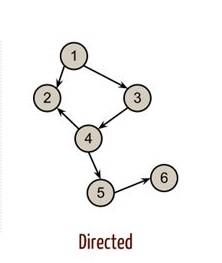

We must therefore prove that one node is connected to another, but that this one is not connected to the first, to be able to say that the graph is directed.

In [17]:
graph[52]

[401135, 1069112, 1163551]

In [18]:
52 in graph[401135]

False

Since we have an edge between node 52 and node 401135 but it's not true the viceversa, the graph is certainly directed.

### Question 2 - Number of nodes

In [19]:
number_of_nodes = len(unique_nodes)
number_of_nodes

461193

### Question 3 - Number of edges

In [20]:
number_of_edges = 0
for val in graph.values():
    number_of_edges += len(val)
number_of_edges

2645247

### Question 4 - Average node degree

The definition of degree of a vertex of a graph is the number of edges incident to the vertex.

To do this and as it will come in handy later, we create a "reverse" graph. With the dictionary shape it will have as key a destination node and as value a list of all the nodes from which an edge starts.

In [21]:
reverse_graph = defaultdict(list)

for key,val in graph.items():
    for elem in val:
        reverse_graph[elem].append(key)
        
    
    

In [22]:
summ = 0
for val in reverse_graph.values():
    summ += len(val)
    

In [23]:
avg_node_degree = summ/len(reverse_graph.keys())
avg_node_degree

7.503863632495362

### Question 5 -  Is the graph dense?

Density of oriented graph is defined as:
$\Delta = \frac{L}{n(n - 1)}$, where n = number of nodes = 461193 and L = number of edges = 2645247

In [24]:
delta = number_of_edges / (number_of_nodes * (number_of_nodes - 1))
delta

1.2436602635647606e-05

The graph isn't really dense.

# RQ2

### Part 1 - Obtain the block-ranking

We have to choose our C0 category:

In [25]:
category = input()

Year_of_birth_unknown


In [26]:
# here I create the structure of the dictionary I use with the Bfs function
len_path = {}
for node in unique_nodes:
    len_path[node] = []

First of all let's implement the BFS algorithm:

Breadth-first search (BFS) is an algorithm for traversing or searching tree or graph data structures. It starts at the tree root (or some arbitrary node of a graph, sometimes referred to as a 'search key'), and explores all of the neighbor nodes at the present depth prior to moving on to the nodes at the next depth level.

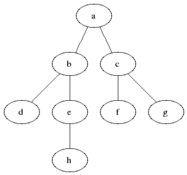

In the specific case our algorithm is slightly modified (To better fit our need to have the nodes outside the starting category and as values the shortest path list from all the starting category nodes that can reach the key node considered) and this is the pseudocode:

- Let's first consider the parent node and set the current distance equal to 0, I initialize queue as the set of the children of the parent node, and visited as the set of the visited nodes.

Until queue has at least one element, that's what we do:

- We increase current distance.

- For each child we append the node with the current distance as value, I find the children of v and I save them in a list and finally I add the node v to the set of visited nodes.

Then we update our queue as the difference between the set of children of v and the set of visited (because It's useless revisit the same node).


In [27]:
def Bfs(g, s, len_path):
    curr_dist = 0 # current distance
    len_path[s].append(curr_dist) # the first element is s himself, so I put a 0 distance.
    queue = set(graph[s]) # the set of the children of s
    visited = set([s]) # the set of the visited items, at the beginning is only s.
    
    while queue:
        
        curr_dist += 1 # update the current distance
        temp = []
        for v in queue: # for each child of s
            len_path[v].append(curr_dist) # append the node with distance equal to curr_dist
            temp += graph[v] # this is the list of the children of v (child of s)
            visited.add(v) # I add in visited the node v
            
        queue = set(temp).difference(visited) # now queue become the difference between set and visited.
        
    return len_path

In [28]:
# for each node in the choosen category, I do Bfs
for node in category_dict[category]:
    len_path = Bfs(graph, node, len_path)


We save the dictionary obtained as a pickle file.

In [29]:
with open('lenpath.pickle', 'wb') as handle:
    pickle.dump(len_path, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
file = open('lenpath.pickle', 'rb')
len_path = pickle.load(file)

Now we have to compute the median to do the block-ranking of the categories respect the starting category.

In [31]:
block_ranking = defaultdict(list)
# number of nodes in requested category
cat_nodes = len(category_dict[category])

for cat in category_dict.keys():
    
    # category requested - median 0
    if cat == category:
        block_ranking[0].append(cat)
     
    else:
        # number of nodes in the category - cat
        cat_n = len(category_dict[cat])
        # length of the list
        tot = cat_n * cat_nodes
        # intialize list of all the shortest paths of this category - cat
        list_path = []
        # iterate all the node in category cat
        for node in category_dict[cat]:
            
            list_path += len_path[node]
        
        if len(list_path) != tot:
            # we add the necessary number of infinites
            list_path += ([np.inf] * (tot - len(list_path)))
        array_path = np.array(list_path)
        
        
        key = np.median(array_path)
        
        # update the block ranking 
        block_ranking[key].append(cat)

In [32]:
with open('blockranking.pickle', 'wb') as handle:
    pickle.dump(block_ranking, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
file1 = open('blockranking.pickle', 'rb')
block_ranking = pickle.load(file1)

In [34]:
block_ranking

defaultdict(list,
            {inf: ['English_footballers',
              'The_Football_League_players',
              'Association_football_forwards',
              'Association_football_goalkeepers',
              'Association_football_midfielders',
              'Association_football_defenders',
              'Living_people',
              'Harvard_University_alumni',
              'Major_League_Baseball_pitchers',
              'Year_of_death_missing',
              'English_cricketers',
              'Year_of_birth_missing_(living_people)',
              'Main_Belt_asteroids',
              'Asteroids_named_for_people',
              'Fellows_of_the_Royal_Society',
              'Year_of_birth_missing',
              'Place_of_birth_missing_(living_people)',
              'American_military_personnel_of_World_War_II',
              'Windows_games'],
             0: ['Year_of_birth_unknown'],
             7.0: ['Members_of_the_United_Kingdom_Parliament_for_English_constituencies',


In [35]:
# initialize a list that will contain the categories sorted
block_ranking_sorted = []
# iterate over the medians sorted...
for median in sorted(block_ranking.keys()):
    # we concatenate the categories
    block_ranking_sorted += block_ranking[median]
block_ranking_sorted

['Year_of_birth_unknown',
 'English-language_films',
 'American_film_actors',
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
 'Indian_films',
 'English_television_actors',
 'British_films',
 'American_films',
 'American_Jews',
 'American_television_actors',
 'Black-and-white_films',
 'Article_Feedback_Pilot',
 'Rivers_of_Romania',
 'English-language_albums',
 'People_from_New_York_City',
 'Debut_albums',
 'English_footballers',
 'The_Football_League_players',
 'Association_football_forwards',
 'Association_football_goalkeepers',
 'Association_football_midfielders',
 'Association_football_defenders',
 'Living_people',
 'Harvard_University_alumni',
 'Major_League_Baseball_pitchers',
 'Year_of_death_missing',
 'English_cricketers',
 'Year_of_birth_missing_(living_people)',
 'Main_Belt_asteroids',
 'Asteroids_named_for_people',
 'Fellows_of_the_Royal_Society',
 'Year_of_birth_missing',
 'Place_of_birth_missing_(living_people)',
 'American_military_personnel_of_Worl

### Part 2 -  Sort the nodes in each category

Now we want to sort the categories using the medians obtained.

In [36]:
# Load the cleaned category file
category_dict = json.load(open('category_dict.json', 'r'))

Now we want build a function that has in input the list of category sorted and for each category we sort the nodes inside. For each category ( = a list of nodes ) we create a dictionary where each keys is a node and its values the weight. In example:

category_0 = [23, 342, 1233, 34, 762]

Using the reverse graph we see that the node 23 is the destination of 2 edges of the same category. Then the new dictionary start with:

categ_0_weighted = { 23 : 2 }

Repeating the procedure for each nodes and we obtain something like this:

categ_0_weighted = { 23 : 2, 342 : 0, 1233 : 1, 34 : 0, 762 : 3 }

In [37]:
def sort_a_category( categ ):
    # initialize a default dict where we store the category with weighted nodes
    category_weighted = defaultdict(int)
    # the list of nodes in this category
    list_of_nodes = category_dict[categ]
    # for all the nodes in that category we compute its weight
    for one_node in list_of_nodes:
        # the KEY is the node and the VALUE is the in-edges of the same category
        category_weighted[one_node] = len(set(reverse_graph[one_node]).intersection(set(list_of_nodes)))
    # at the end we return the dictionary of the category weighted      
    return(category_weighted)

Now we want a function that add the weight of the in-edge of the previous category. So we take in input the new category to weight and the previous ( where the order was decided in the block ranking ).

In [38]:
def sort_with_previous_categ ( current_categ, previous_categ_weighted ):
    # First of all we weight all of nodes according to in-edges of the same category
    category_weighted = sort_a_category( current_categ )
    # the list of nodes in this category
    list_of_nodes = category_dict[current_categ]
    # for all the nodes in that category...
    for one_node in list_of_nodes:
        # we search all the nodes in the previous category that have as a destination "one_node".
        # And iterating over this...
        for neighboor_node in list(set(reverse_graph[one_node]).intersection(set(previous_categ_weighted.keys()))):
            # we add to "one_node" the weight of the source node
            category_weighted[one_node] += previous_categ_weighted[neighboor_node]
    # at the end we return the current weighted category
    return category_weighted

In [39]:
def sort_the_graph( block_ranked ):
    # computed the weight for the first category
    previous_cat = sort_a_category(block_ranked[0])
    # sort the elements in descending order by values ( = weights of the nodes)
    sorted_by_value = sorted(previous_cat.items(), key=lambda kv: kv[1], reverse=True)
    # initialize the output list where we will have the nodes ordered by category and weight
    output_list = [k for k,v in sorted_by_value]
    # we repeat all the process for the following categories after the first
    for categ_name in block_ranked[1:]:
        previous_cat = sort_with_previous_categ(categ_name, previous_cat)
        sorted_by_value = sorted(previous_cat.items(), key=lambda kv: kv[1], reverse=True)
        output_list += [k for k,v in sorted_by_value if k not in output_list]
    return output_list

In [40]:
ordered_articles = sort_the_graph( block_ranking_sorted )

In [41]:
with open('listfile.data', 'wb') as filehandle:  
    # store the data as binary data stream
    pickle.dump(ordered_articles, filehandle)

In [42]:
with open('listfile.data', 'rb') as filehandle:  
    # read the data as binary data stream
    ordered_articles = pickle.load(filehandle)

In [43]:
# Example of the output with input category C0 = Year_of_birth_unknown
print(ordered_articles[:100])

[62684, 170163, 1656777, 1656780, 169696, 1656794, 170578, 1342864, 1343014, 1656778, 666855, 1342960, 1779656, 174582, 1109348, 1109485, 159606, 159730, 159920, 1766063, 1203095, 1203235, 64632, 1203496, 1122762, 1344701, 34422, 1443739, 174427, 174439, 166284, 666857, 159750, 168001, 168145, 168251, 168258, 1765824, 1765831, 1765837, 185120, 62695, 1340874, 170158, 1203101, 170969, 170970, 170971, 170972, 170973, 1342803, 1343206, 958480, 172050, 1319048, 360595, 1122603, 1122605, 156307, 173221, 1344730, 1344821, 173671, 1656450, 1656452, 1656453, 1656455, 1443741, 1656779, 1656793, 1779795, 1779800, 174428, 1345946, 1345947, 1190355, 60061, 175366, 1109359, 159614, 167906, 159736, 159749, 159753, 159754, 159766, 167966, 168100, 159914, 159934, 176367, 168194, 1765823, 1765832, 1765845, 1765848, 201333, 1684172, 324414, 1766449]
